In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier

In [2]:
# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [12]:
train_csv = "/Users/dana/Desktop/AHI/01_PAML/Project/ML_project_AHI_2025/Part_2/train_pca_data_imputed.csv"
test_csv  = "/Users/dana/Desktop/AHI/01_PAML/Project/ML_project_AHI_2025/Part_2/test_pca_data_imputed.csv"

In [13]:
df_train = pd.read_csv(train_csv)
df_test  = pd.read_csv(test_csv)

# Features and target
X_train = df_train.drop(columns=["er"])
y_train = df_train["er"]

X_test = df_test.drop(columns=["er"])
y_test = df_test["er"]

# Define models 

In [ ]:
# Logistic Regression
lr_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        C=1.0,
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_SEED
    ))
])

# Random Forest
rf_pipeline = Pipeline(steps=[
    ("rf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=RANDOM_SEED
    ))
])

# XGBoost (no scaler needed)
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=RANDOM_SEED
)

# Hyperparameter search for xgboost
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)

In [24]:
# Train models

lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_
print("Best XGBoost parameters:")
print(xgb_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost parameters:
{'subsample': 0.7, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


# Evaluation

In [ ]:
models = {
    "Logistic Regression": lr_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": best_xgb}

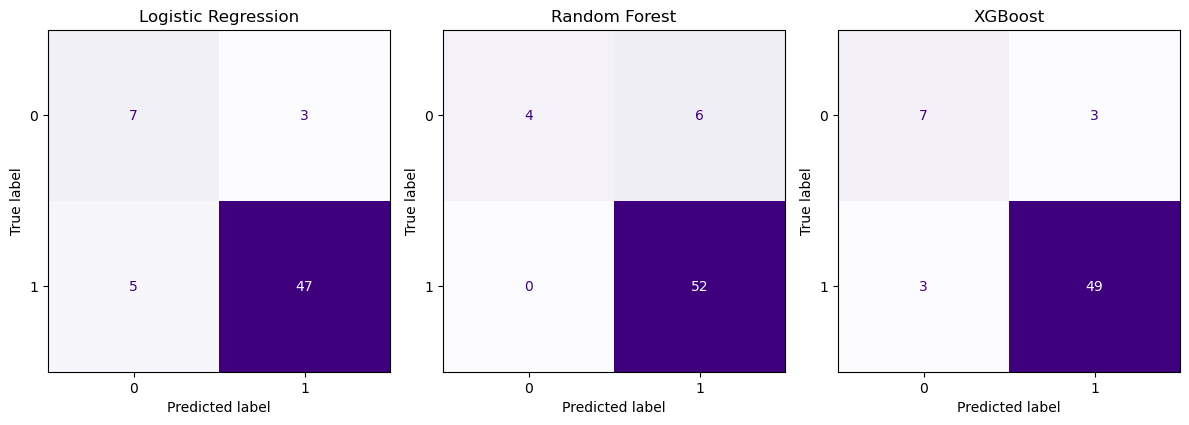

In [38]:
results = []

plt.figure(figsize=(12, 5))

for i, (name, model) in enumerate(models.items(), 1):

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "ROC-AUC": roc
    })

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])

    plt.subplot(1, 3, i)
    disp.plot(ax=plt.gca(), cmap="Purples", colorbar=False)
    plt.title(name)

plt.tight_layout()
plt.savefig("ConfusionMatrix_LR_RF_XGB.png", dpi=300)
plt.show()

In [35]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,ROC-AUC
0,Logistic Regression,0.870968,0.940000,0.869231
1,Random Forest,0.903226,0.896552,0.948077
2,XGBoost,0.903226,0.942308,0.903846


In [36]:
# Results summary
print(results_df.sort_values(by="ROC-AUC", ascending=False))

                 Model  Accuracy  Precision   ROC-AUC
1        Random Forest  0.903226   0.896552  0.948077
2              XGBoost  0.903226   0.942308  0.903846
0  Logistic Regression  0.870968   0.940000  0.869231
